In [92]:
# !pip install clearml

In [97]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=PASTE_KEY
%env CLEARML_API_SECRET_KEY=PASTE_KEY

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=PASTE_KEY
env: CLEARML_API_SECRET_KEY=PASTE_KEY


In [96]:
from clearml import Task, Logger

# Initialize ClearML Task
task = Task.init(
    project_name="VAE Experiments",
    task_name="VAE with KL vs Wasserstein Loss",
    task_type=Task.TaskTypes.training
)

ClearML Task: created new task id=df32e53dc3cc4211ae8fd4203dc4277b
2025-01-19 14:46:48,286 - clearml.Repository Detection - WARNING - Could not read Jupyter Notebook: No module named 'nbconvert'
2025-01-19 14:46:48,293 - clearml.Repository Detection - WARNING - Please install nbconvert using "pip install nbconvert"
2025-01-19 14:46:48,352 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/468c1a1bdfaf45d38d7f80abcd3f141c/experiments/df32e53dc3cc4211ae8fd4203dc4277b/output/log


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


# **Experiment Description**

In this experiment, the goal is to compare the performance of a Variational Autoencoder (VAE) using two different loss functions: **KL divergence** and the **Wasserstein metric**.  

1. **Objective**:
   - Understand how the choice of the divergence/metric in the loss function affects the quality of latent representations and reconstructed data.
   - Compare the performance in terms of reconstruction quality, latent space structure, and generalization ability.

2. **Steps**:
   - **Implement a Simple VAE**:
     - Design a basic VAE architecture with fully connected layers for encoding and decoding.
     - Use a Gaussian prior for the latent space and a reparameterization trick for sampling.
   - **Train the VAE with KL Divergence**:
     - Use the KL divergence to regularize the latent space to match the prior distribution.
   - **Train the VAE with the Wasserstein Metric**:
     - Replace the KL divergence with the Wasserstein metric to regularize the latent space.
   - **Evaluate and Compare**:
     - Assess reconstruction quality using metrics like Mean Squared Error (MSE) on the test dataset.
     - Visualize the learned latent space for each loss function using 2D projections.
     - Compare training stability and convergence speed for both loss functions.

3. **Expected Outcome**:
   - The KL divergence is likely to yield good performance for Gaussian priors but may suffer from issues like posterior collapse.
   - The Wasserstein metric might provide smoother optimization and better latent space representations, especially if the data distribution differs significantly from the Gaussian prior.

By comparing the results, you’ll gain insights into the strengths and weaknesses of each approach in the context of VAEs.

___


### **1. What is a VAE?**
A VAE is a type of neural network used to generate data, such as images or text. It learns to compress input data into a **latent space** (a compact, lower-dimensional representation) and then reconstruct or generate new data from this latent space.

---

### **2. How Does It Work?**
VAEs consist of two main parts:

#### **a) Encoder**
- The encoder takes an input (e.g., an image) and compresses it into a **latent representation**.  
- Instead of producing a single point, the encoder outputs the **parameters of a probability distribution** in the latent space (mean $\mu$ and standard deviation $\sigma$).
- This means the latent space is a random variable, not a fixed value.  

#### **b) Decoder**
- The decoder takes a sample from the latent distribution and tries to reconstruct the original input from it.
- It learns to map points in the latent space back to the input space.

---

### **3. Why Use a Latent Distribution?**
Instead of just learning fixed points in the latent space, the VAE learns a **distribution** (e.g., a Gaussian) for each input. This has two advantages:
1. **Generative Capability:** By sampling from the latent distribution, the VAE can generate new data points that resemble the training data.
2. **Smooth Latent Space:** Close points in the latent space correspond to similar outputs, making it easier to interpolate between data points.

---

### **4. Loss Function**
The VAE is trained using two objectives:
1. **Reconstruction Loss:** Ensures the decoder reconstructs the input accurately. Typically, this is the mean squared error (for continuous data) or cross-entropy (for categorical data).
   $$
   \text{Reconstruction Loss} = \| x - \hat{x} \|^2
   $$

2. **KL Divergence:** Ensures the latent space follows a standard Gaussian distribution $\mathcal{N}(0, I)$. This regularizes the latent space and encourages smoothness.
   $$
   \text{KL Divergence} = D_{KL}(q(z|x) \,||\, p(z))
   $$

The total loss combines these two:
$$
\text{Total Loss} = \text{Reconstruction Loss} + \beta \cdot \text{KL Divergence}
$$
(where $\beta$ balances the two terms).

---

### **5. Training Process**
1. **Input to Latent Space:** The encoder takes an input $x$ and outputs $\mu(x)$ and $\sigma(x)$, the parameters of the latent distribution $q(z|x)$.
2. **Sampling (Reparameterization Trick):** A random sample $z$ is drawn from $q(z|x)$, using:
   $$
   z = \mu(x) + \sigma(x) \cdot \epsilon
   $$
   where $\epsilon \sim \mathcal{N}(0, I)$.
3. **Reconstruction:** The decoder uses $z$ to generate $\hat{x}$, the reconstruction of the input.
4. **Loss Minimization:** The loss (reconstruction + KL divergence) is minimized via gradient descent.

---

### **6. What Can VAEs Do?**
- **Data Generation:** VAEs can generate new data by sampling from the latent space and passing it through the decoder.
- **Interpolation:** Since the latent space is smooth, VAEs can interpolate between points, creating transitions between data samples (e.g., blending images).
- **Anomaly Detection:** VAEs can identify anomalies by measuring how well they can reconstruct inputs (poor reconstruction indicates unusual data).

---

### **Simple Analogy**
Think of the VAE like a painter:
1. The **encoder** describes an image by summarizing it into a set of instructions (latent distribution).
2. The **decoder** takes those instructions and tries to recreate the original image.
3. During training, the VAE learns to make its instructions compact and consistent while still being able to reconstruct accurately.

# **EXPERIMENT**

### VAE Architecture
A VAE consists of:
- **Encoder:** Maps input data to a latent distribution (mean and log-variance).
- **Latent Space Sampling:** Reparameterization trick for sampling latent vectors.
- **Decoder:** Reconstructs data from latent vectors.

In [ ]:
import torch
from torch import nn

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # Output both mean and log-variance
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # encoder pass
        h = self.encoder(x)

        # Attempts to split a tensor into the specified number of chunks. Each chunk is a view of the input tensor.
        mu, log_var = torch.chunk(h, 2, dim=-1) 
        
        # sampling
        z = self.reparameterize(mu, log_var)

        return self.decoder(z), mu, log_var


# Loss Functions

**KL Divergence Loss:**

In [2]:
def kl_divergence_loss(mu, log_var):
    return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

**Wasserstein Metric Loss:**

In [9]:
def wasserstein_loss(real, fake):
    return torch.mean(torch.abs(real - fake))  # Example metric

# Above, for simplicity, PyTorch's Sinkhorn distance is used. Normal loss function will be introduced later.

**Reconstruction Loss (common for both):**

In [4]:
def reconstruction_loss(recon_x, x):
    return nn.BCELoss(reduction='sum')(recon_x, x)

### Total Loss:

In [6]:
def vae_loss(recon_x, x, mu, log_var, loss_type="kl"):
    recon_loss = reconstruction_loss(recon_x, x)

    if loss_type == "kl":
        reg_loss = kl_divergence_loss(mu, log_var)
    
    elif loss_type == "wasserstein":
        reg_loss = wasserstein_loss(x, recon_x)
    
    return recon_loss + reg_loss

# Dataset

In [10]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

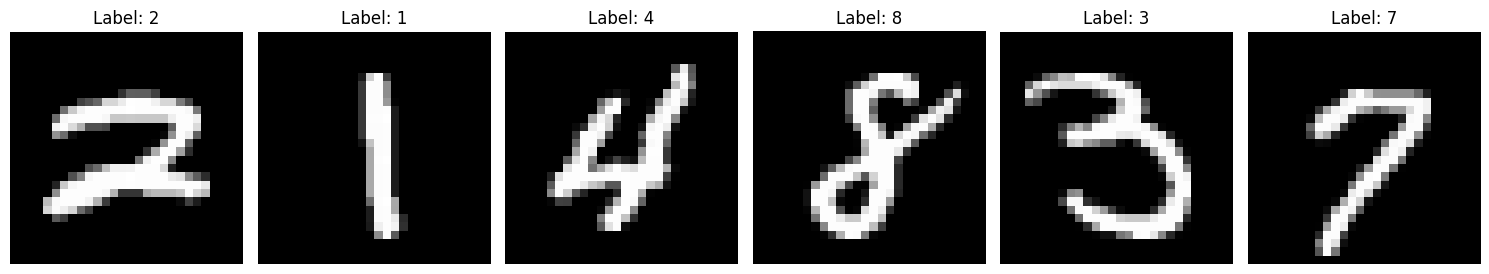

In [15]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Plot some examples from the dataset
fig, axes = plt.subplots(1, 6, figsize=(15, 4))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap="gray")
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [19]:
x = images[i]
print(x.shape)
print()
print(x.view(x.size(0), -1).shape)

torch.Size([1, 28, 28])

torch.Size([1, 784])


# Training with KL Divergence

In [16]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
device = torch.device("cuda" if use_cuda else "mps" if use_mps else "cpu")

In [26]:
from tqdm import tqdm

# Training Function
def train_vae(vae, data_loader, optimizer, epochs=10):
    vae.train()
    train_loss = []
    for epoch in range(epochs):
        total_loss = 0
        with tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for x, _ in pbar:
                x = x.view(x.size(0), -1).to(device)  # Flatten input
                optimizer.zero_grad()
                recon_x, mu, log_var = vae(x)
                loss = vae_loss(recon_x, x, mu, log_var)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pbar.set_postfix(loss=loss.item())
        avg_loss = total_loss / len(data_loader.dataset)
        train_loss.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    return train_loss

In [27]:
# Hyperparameters
input_dim = 28 * 28  # Flattened MNIST images
latent_dim = 10
batch_size = 64
learning_rate = 1e-3
epochs = 25

# Model, Optimizer
vae = VAE(input_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

Epoch 1/25:   0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 1/25: 100%|██████████| 938/938 [00:09<00:00, 102.11batch/s, loss=4.64e+3]


Epoch 1, Loss: 166.3604


Epoch 2/25: 100%|██████████| 938/938 [00:09<00:00, 95.40batch/s, loss=4.06e+3] 


Epoch 2, Loss: 130.2931


Epoch 3/25: 100%|██████████| 938/938 [00:09<00:00, 97.09batch/s, loss=3.86e+3] 


Epoch 3, Loss: 124.5309


Epoch 4/25: 100%|██████████| 938/938 [00:08<00:00, 107.28batch/s, loss=3.8e+3] 


Epoch 4, Loss: 121.4722


Epoch 5/25: 100%|██████████| 938/938 [00:08<00:00, 104.46batch/s, loss=3.38e+3]


Epoch 5, Loss: 119.5512


Epoch 6/25: 100%|██████████| 938/938 [00:08<00:00, 107.30batch/s, loss=4.02e+3]


Epoch 6, Loss: 118.2828


Epoch 7/25: 100%|██████████| 938/938 [00:09<00:00, 100.54batch/s, loss=3.74e+3]


Epoch 7, Loss: 117.3751


Epoch 8/25: 100%|██████████| 938/938 [00:08<00:00, 107.84batch/s, loss=3.74e+3]


Epoch 8, Loss: 116.6434


Epoch 9/25: 100%|██████████| 938/938 [00:08<00:00, 114.19batch/s, loss=3.93e+3]


Epoch 9, Loss: 116.0984


Epoch 10/25: 100%|██████████| 938/938 [00:08<00:00, 113.13batch/s, loss=4.03e+3]


Epoch 10, Loss: 115.6307


Epoch 11/25: 100%|██████████| 938/938 [00:08<00:00, 110.96batch/s, loss=3.74e+3]


Epoch 11, Loss: 115.2169


Epoch 12/25: 100%|██████████| 938/938 [00:09<00:00, 104.10batch/s, loss=3.79e+3]


Epoch 12, Loss: 114.8664


Epoch 13/25: 100%|██████████| 938/938 [00:08<00:00, 104.32batch/s, loss=3.59e+3]


Epoch 13, Loss: 114.5826


Epoch 14/25: 100%|██████████| 938/938 [00:09<00:00, 97.23batch/s, loss=3.71e+3] 


Epoch 14, Loss: 114.3416


Epoch 15/25: 100%|██████████| 938/938 [00:09<00:00, 98.91batch/s, loss=3.62e+3] 


Epoch 15, Loss: 114.0791


Epoch 16/25: 100%|██████████| 938/938 [00:09<00:00, 97.20batch/s, loss=3.53e+3] 


Epoch 16, Loss: 113.8330


Epoch 17/25: 100%|██████████| 938/938 [00:09<00:00, 99.85batch/s, loss=3.54e+3] 


Epoch 17, Loss: 113.6498


Epoch 18/25: 100%|██████████| 938/938 [00:09<00:00, 96.88batch/s, loss=3.5e+3]  


Epoch 18, Loss: 113.4497


Epoch 19/25: 100%|██████████| 938/938 [00:09<00:00, 96.10batch/s, loss=3.57e+3] 


Epoch 19, Loss: 113.2857


Epoch 20/25: 100%|██████████| 938/938 [00:09<00:00, 94.71batch/s, loss=3.71e+3] 


Epoch 20, Loss: 113.1238


Epoch 21/25: 100%|██████████| 938/938 [00:09<00:00, 95.72batch/s, loss=3.48e+3] 


Epoch 21, Loss: 112.9615


Epoch 22/25: 100%|██████████| 938/938 [00:09<00:00, 96.12batch/s, loss=3.59e+3] 


Epoch 22, Loss: 112.8706


Epoch 23/25: 100%|██████████| 938/938 [00:09<00:00, 102.04batch/s, loss=3.83e+3]


Epoch 23, Loss: 112.6926


Epoch 24/25: 100%|██████████| 938/938 [00:09<00:00, 100.16batch/s, loss=3.47e+3]


Epoch 24, Loss: 112.5943


Epoch 25/25: 100%|██████████| 938/938 [00:10<00:00, 92.53batch/s, loss=3.5e+3]  


Epoch 25, Loss: 112.4586


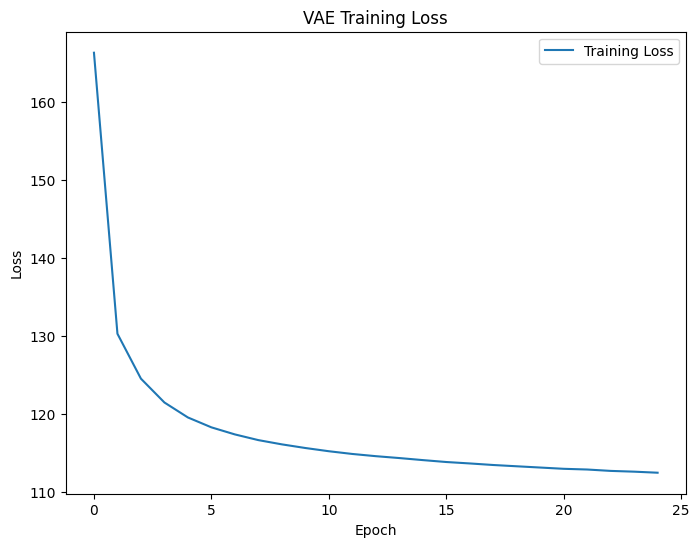

In [28]:
# Train VAE
train_loss = train_vae(vae, train_loader, optimizer, epochs)

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()

# Plot Results

In [29]:
# Plot Results
def plot_results(vae, data_loader, num_samples=10):
    vae.eval()
    with torch.no_grad():
        # Get a batch of samples
        x, _ = next(iter(data_loader))
        x = x.view(x.size(0), -1).to(device)

        # Generate Reconstructions
        recon_x, _, _ = vae(x)

        # Plot Original and Reconstructed Images
        fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
        for i in range(num_samples):
            # Original images
            axes[0, i].imshow(x[i].cpu().view(28, 28), cmap='gray')
            axes[0, i].axis('off')
            # Reconstructed images
            axes[1, i].imshow(recon_x[i].cpu().view(28, 28), cmap='gray')
            axes[1, i].axis('off')
        axes[0, 0].set_ylabel("Original", fontsize=14)
        axes[1, 0].set_ylabel("Reconstructed", fontsize=14)
        plt.show()

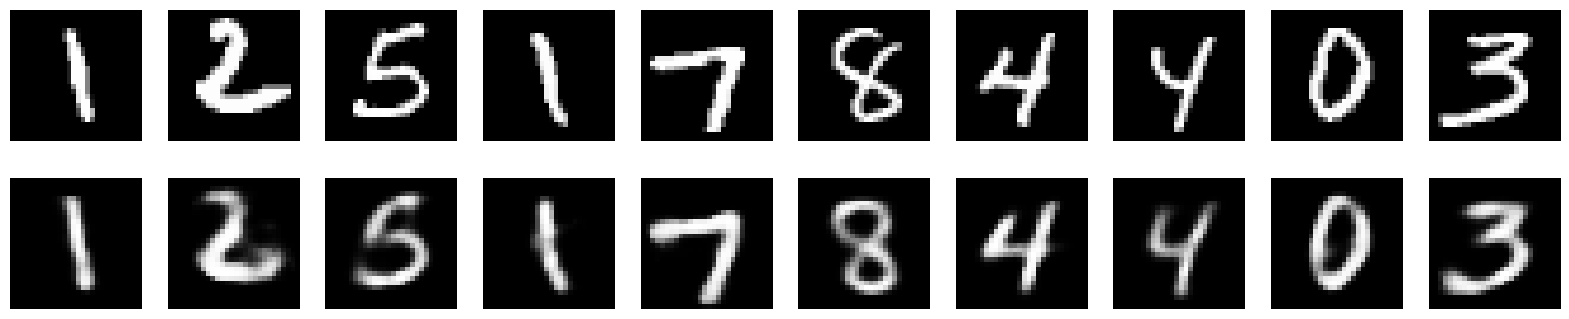

In [30]:
# Plot Reconstructions
plot_results(vae, train_loader)

In the plot above:
- **first row:** original image from MNIST
- **second row:** reconstructed image with VAE

In [ ]:
from sklearn.manifold import TSNE

def plot_latent_space(vae, data_loader):
    vae.eval()
    with torch.no_grad():
        all_mu = []
        all_labels = []
        for x, y in data_loader:
            x = x.view(x.size(0), -1).to(device)
            _, mu, _ = vae(x)
            all_mu.append(mu.cpu())
            all_labels.append(y)
        
        all_mu = torch.cat(all_mu)
        all_labels = torch.cat(all_labels)

        # Dimensionality reduction
        
        reduced = TSNE(n_components=2).fit_transform(all_mu)

        # Plot
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, label="Digit Label")
        plt.title(f"Latent Space Visualization (TSNE)")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.show()


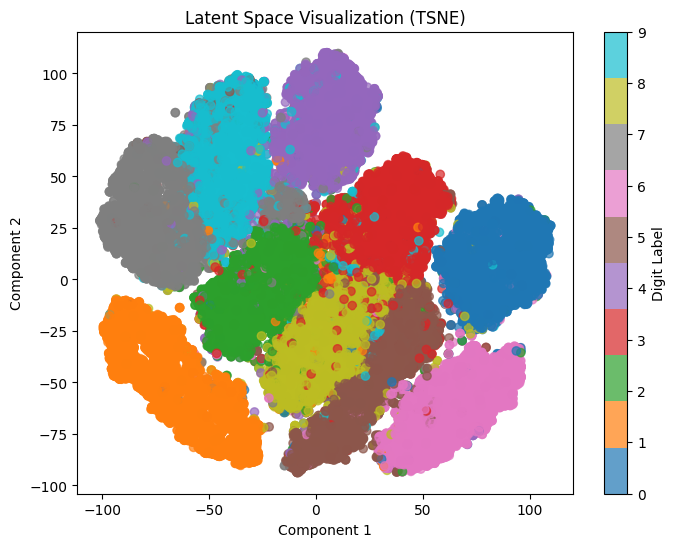

In [35]:
plot_latent_space(vae, train_loader, method="tsne")

In [38]:
import seaborn as sns

def plot_latent_distributions(vae, data_loader):
    vae.eval()
    with torch.no_grad():
        all_mu = []
        for x, _ in data_loader:
            x = x.view(x.size(0), -1).to(device)
            _, mu, _ = vae(x)
            all_mu.append(mu.cpu())
        all_mu = torch.cat(all_mu)

    # Plot distribution for each latent dimension
    num_latent_dims = all_mu.shape[1]
    fig, axes = plt.subplots(1, num_latent_dims, figsize=(num_latent_dims * 3, 4), sharey=True)
    for i in range(num_latent_dims):
        sns.kdeplot(all_mu[:, i], ax=axes[i], fill=True)
        axes[i].set_title(f"Latent Dim {i+1}")
    plt.tight_layout()
    plt.show()


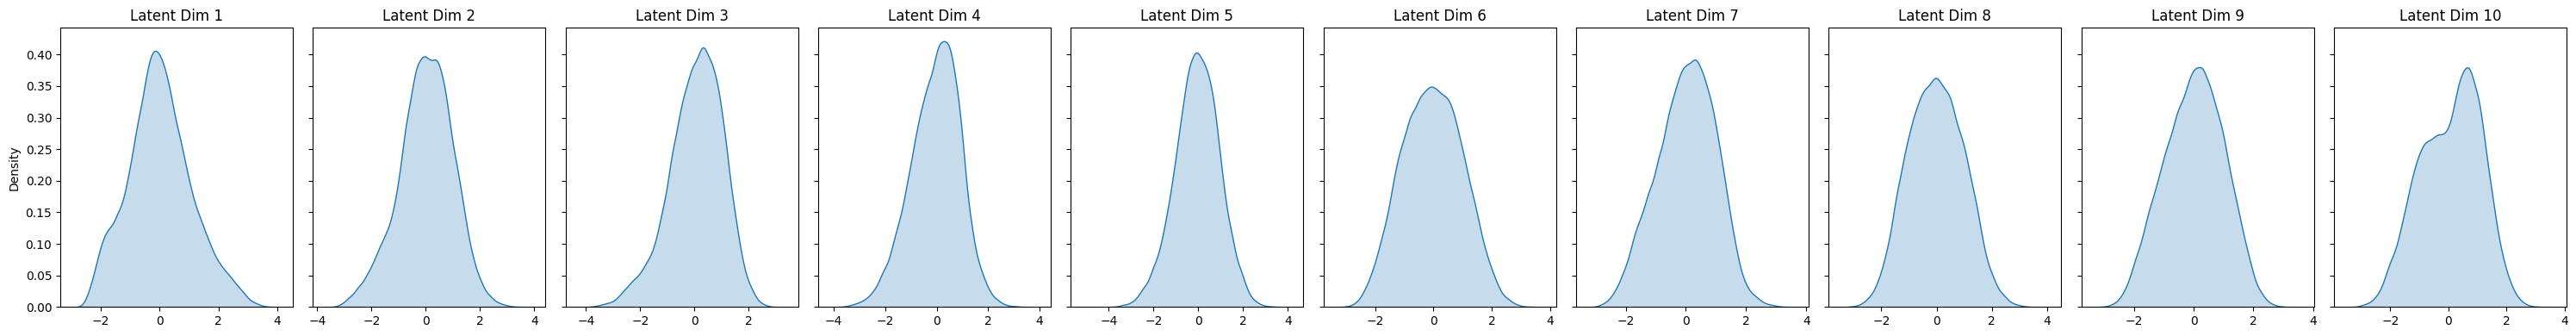

In [39]:
# This helps to see how well the latent space approximates a Gaussian distribution.
plot_latent_distributions(vae, train_loader)

In [40]:
def plot_interpolation(vae, data_loader, dim=0, num_steps=10):
    vae.eval()
    with torch.no_grad():
        # Get two random samples
        x, _ = next(iter(data_loader))
        x = x.view(x.size(0), -1).to(device)
        _, mu, _ = vae(x)

        # Select two points in the latent space
        z1, z2 = mu[0], mu[1]
        interpolation = torch.stack([z1 * (1 - t) + z2 * t for t in torch.linspace(0, 1, num_steps)])

        # Decode interpolated points
        reconstructions = vae.decoder(interpolation)

        # Plot
        fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 2))
        for i in range(num_steps):
            axes[i].imshow(reconstructions[i].cpu().view(28, 28), cmap='gray')
            axes[i].axis('off')
        plt.show()

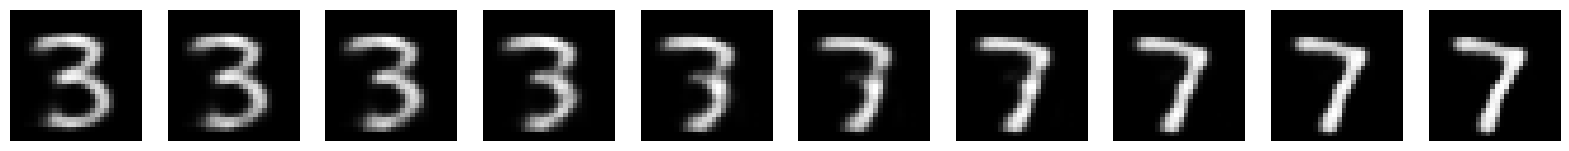

In [41]:
plot_interpolation(vae, train_loader, num_steps=10)

In [42]:
def plot_reconstruction_error(vae, data_loader):
    vae.eval()
    errors = []
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.view(x.size(0), -1).to(device)
            recon_x, _, _ = vae(x)
            error = ((x - recon_x) ** 2).sum(dim=1)
            errors.extend(error.cpu().numpy())
    
    # Plot histogram of reconstruction errors
    plt.figure(figsize=(8, 6))
    plt.hist(errors, bins=50, alpha=0.7)
    plt.title("Reconstruction Error Distribution")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.show()

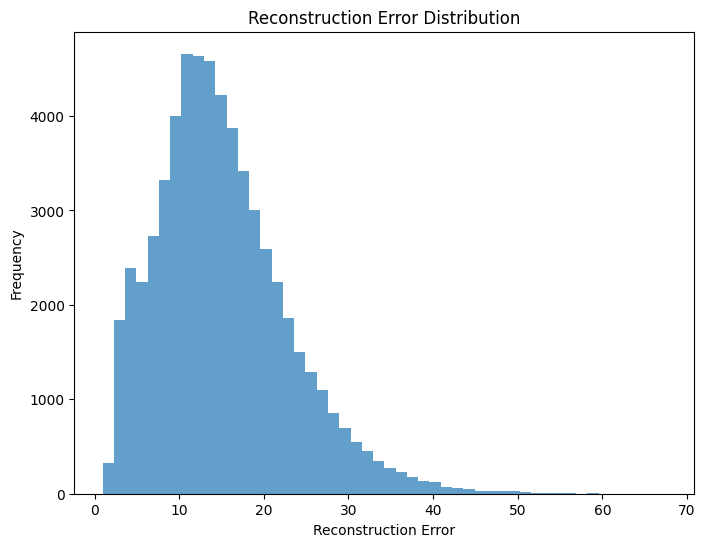

In [43]:
plot_reconstruction_error(vae, train_loader)

# **BEFORE YOU SAW THE ORIGINAL VAE WITH KL DIVERGENCE IN THE LOSS FUNCTUON**

NOW, LETS SEE WHAT WILL HAPPEN, IF WE USE WASSERSTEIN DISTANCE

# True Wasserstein loss

The Wasserstein loss isn't the same as the simple absolute difference metric I used as a placeholder before. Let’s dive deeper into the exact Wasserstein loss and its correct application.

The exact Wasserstein distance, however, is computationally expensive because it requires solving an optimization problem. Instead, **Wasserstein GANs (WGANs)** introduce the **Kantorovich-Rubinstein duality**, making it feasible to approximate Wasserstein distance efficiently by parameterizing the critic as a neural network.

### Correct Implementation of Wasserstein Loss in a VAE

Here’s how we can incorporate the Wasserstein loss correctly in a VAE:

1. **Latent Space Comparison**:
   - Instead of KL divergence between the latent distribution $q(z|x)$ and a prior distribution $p(z)$ (usually a standard Gaussian), we use the Wasserstein distance between these distributions.

2. **Dual Form Approximation**:
   - To approximate the Wasserstein distance, use a critic (discriminator-like network) that estimates the cost of transporting probability mass.

3. **Key Additions**:
   - Introduce a **critic network** $D(z)$ for the latent space.
   - Train the critic to maximize the difference between the real distribution $p(z)$ (e.g., standard Gaussian) and the generated distribution $q(z|x)$.

### Wasserstein Loss Implementation for VAE

Here’s how to adapt the VAE with Wasserstein loss:

In [81]:
# Define a simple fully connected network as the critic:
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),  # Increase hidden layer size
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )


    def forward(self, x):
        return self.model(x)


def wasserstein_loss_vae(critic, z_real, z_fake):
    """
    Wasserstein loss for the latent space.
    """
    real_score = critic(z_real)  # Critic output for real samples (from prior p(z))
    fake_score = critic(z_fake)  # Critic output for generated samples (from q(z|x))
    return torch.mean(fake_score) - torch.mean(real_score)  # W-distance approximation

'''
In Wasserstein GANs (WGANs), the discriminator (critic) must be 1-Lipschitz continuous 
to calculate the Wasserstein distance accurately. The Lipschitz constraint ensures that 
the critic does not "explode" and maintains meaningful gradients for optimization. This 
is crucial for stable training and meaningful results.
''' 

# To ensure the critic satisfies the Lipschitz constraint, add a gradient penalty:
def gradient_penalty(critic, z_real, z_fake):
    """
    Compute gradient penalty for Lipschitz constraint.
    """
    alpha = torch.rand(z_real.size(0), 1).to(z_real.device)
    z_interpolates = alpha * z_real + (1 - alpha) * z_fake 
    z_interpolates.requires_grad_(True)

    critic_scores = critic(z_interpolates)
    gradients = torch.autograd.grad(
        outputs=critic_scores,
        inputs=z_interpolates,
        grad_outputs=torch.ones_like(critic_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

In [82]:
# Training Function
def train_wvae(vae, critic, data_loader, vae_optimizer, critic_optimizer, epochs=10, gp_weight=10.0, critic_updates_per_step=5):
    vae.train()
    critic.train()

    for epoch in range(epochs):
        total_critic_loss = 0
        total_vae_loss = 0

        with tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for x, _ in pbar:
            
                x = x.view(x.size(0), -1).to(device)

                # Update Critic multiple times per VAE step
                for _ in range(critic_updates_per_step):
                    # Forward pass through VAE (detach z_fake for critic update)
                    recon_x, mu, log_var = vae(x)
                    z_fake = vae.reparameterize(mu, log_var).detach()

                    # Returns a tensor with the same size as input that is filled 
                    # with random numbers from a normal distribution with mean 0 and variance 1.
                    z_real = torch.randn_like(z_fake).to(device)  # Prior samples

                    # Critic loss
                    critic_optimizer.zero_grad()
                    w_loss = wasserstein_loss_vae(critic, z_real, z_fake)
                    gp = gradient_penalty(critic, z_real, z_fake)
                    critic_loss = w_loss + gp_weight * gp
                    critic_loss.backward()
                    critic_optimizer.step()

                    total_critic_loss += critic_loss.item()

                # Update VAE
                vae_optimizer.zero_grad()
                recon_loss = reconstruction_loss(recon_x, x)
                z_fake = vae.reparameterize(mu, log_var)  # Recompute z_fake for VAE update
                w_loss_vae = -torch.mean(critic(z_fake))  # Critic loss for generated samples
                vae_loss = 0.1 * recon_loss + w_loss_vae
                vae_loss.backward()
                vae_optimizer.step()

                total_vae_loss += vae_loss.item()
                pbar.set_postfix(loss=vae_loss.item())

        print(
            f"Epoch {epoch + 1}, Critic Loss: {total_critic_loss / len(data_loader):.4f}, "
            f"VAE Loss: {total_vae_loss / len(data_loader):.4f}"
        )

In [83]:
# Hyperparameters
input_dim = 28 * 28  # Flattened MNIST images
latent_dim = 10
batch_size = 64
epochs = 25
gp_weight = 5.0

# Model, Optimizers
vae2 = VAE(input_dim, latent_dim).to(device)
critic = Critic(latent_dim).to(device)
vae2_optimizer = torch.optim.Adam(vae2.parameters(), lr=1e-3)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-3)

In [84]:
# Train W-VAE
train_wvae(vae2, critic, train_loader, vae2_optimizer, critic_optimizer, epochs, gp_weight)

Epoch 1/25: 100%|██████████| 938/938 [00:45<00:00, 20.54batch/s, loss=358]    


Epoch 1, Critic Loss: -69.4610, VAE Loss: 923.1992


Epoch 2/25: 100%|██████████| 938/938 [00:43<00:00, 21.53batch/s, loss=321]


Epoch 2, Critic Loss: -51.9625, VAE Loss: 682.3287


Epoch 3/25: 100%|██████████| 938/938 [00:43<00:00, 21.42batch/s, loss=338]


Epoch 3, Critic Loss: -45.4217, VAE Loss: 650.8323


Epoch 4/25: 100%|██████████| 938/938 [00:44<00:00, 21.22batch/s, loss=317]


Epoch 4, Critic Loss: -40.7054, VAE Loss: 632.3668


Epoch 5/25: 100%|██████████| 938/938 [00:43<00:00, 21.66batch/s, loss=329]


Epoch 5, Critic Loss: -37.1043, VAE Loss: 619.9892


Epoch 6/25: 100%|██████████| 938/938 [00:43<00:00, 21.78batch/s, loss=305]


Epoch 6, Critic Loss: -34.1433, VAE Loss: 611.3908


Epoch 7/25: 100%|██████████| 938/938 [00:43<00:00, 21.63batch/s, loss=297]


Epoch 7, Critic Loss: -31.5709, VAE Loss: 604.8529


Epoch 8/25: 100%|██████████| 938/938 [00:43<00:00, 21.67batch/s, loss=315]


Epoch 8, Critic Loss: -29.6198, VAE Loss: 599.7067


Epoch 9/25: 100%|██████████| 938/938 [00:43<00:00, 21.58batch/s, loss=316]


Epoch 9, Critic Loss: -27.7760, VAE Loss: 595.3038


Epoch 10/25: 100%|██████████| 938/938 [00:43<00:00, 21.66batch/s, loss=330]


Epoch 10, Critic Loss: -26.3926, VAE Loss: 591.4631


Epoch 11/25: 100%|██████████| 938/938 [00:43<00:00, 21.62batch/s, loss=299]


Epoch 11, Critic Loss: -25.0655, VAE Loss: 588.0728


Epoch 12/25: 100%|██████████| 938/938 [00:43<00:00, 21.61batch/s, loss=302]


Epoch 12, Critic Loss: -24.0177, VAE Loss: 584.8404


Epoch 13/25: 100%|██████████| 938/938 [00:43<00:00, 21.69batch/s, loss=339]


Epoch 13, Critic Loss: -22.9539, VAE Loss: 582.0499


Epoch 14/25: 100%|██████████| 938/938 [00:43<00:00, 21.70batch/s, loss=252]


Epoch 14, Critic Loss: -22.0602, VAE Loss: 579.6333


Epoch 15/25: 100%|██████████| 938/938 [00:43<00:00, 21.47batch/s, loss=301]


Epoch 15, Critic Loss: -21.2326, VAE Loss: 577.4227


Epoch 16/25: 100%|██████████| 938/938 [00:43<00:00, 21.59batch/s, loss=294]


Epoch 16, Critic Loss: -20.4146, VAE Loss: 575.3910


Epoch 17/25: 100%|██████████| 938/938 [00:42<00:00, 21.92batch/s, loss=269]


Epoch 17, Critic Loss: -19.7535, VAE Loss: 573.3708


Epoch 18/25: 100%|██████████| 938/938 [00:42<00:00, 21.99batch/s, loss=273]


Epoch 18, Critic Loss: -19.0796, VAE Loss: 571.6858


Epoch 19/25: 100%|██████████| 938/938 [00:42<00:00, 21.95batch/s, loss=292]


Epoch 19, Critic Loss: -18.4935, VAE Loss: 570.2987


Epoch 20/25: 100%|██████████| 938/938 [00:43<00:00, 21.67batch/s, loss=308]


Epoch 20, Critic Loss: -17.8460, VAE Loss: 568.7959


Epoch 21/25: 100%|██████████| 938/938 [00:43<00:00, 21.69batch/s, loss=265]


Epoch 21, Critic Loss: -17.3517, VAE Loss: 567.5756


Epoch 22/25: 100%|██████████| 938/938 [00:43<00:00, 21.61batch/s, loss=256]


Epoch 22, Critic Loss: -16.8843, VAE Loss: 566.3166


Epoch 23/25: 100%|██████████| 938/938 [00:43<00:00, 21.59batch/s, loss=269]


Epoch 23, Critic Loss: -16.3923, VAE Loss: 565.4102


Epoch 24/25: 100%|██████████| 938/938 [00:44<00:00, 21.26batch/s, loss=271]


Epoch 24, Critic Loss: -15.9694, VAE Loss: 564.3843


Epoch 25/25: 100%|██████████| 938/938 [00:45<00:00, 20.57batch/s, loss=266]

Epoch 25, Critic Loss: -15.5347, VAE Loss: 563.4573


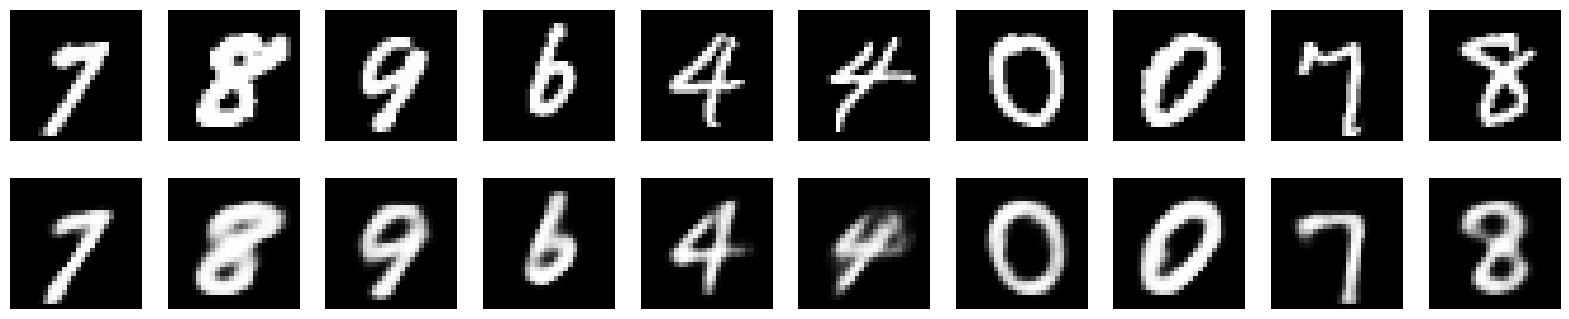

In [85]:
plot_results(vae2, train_loader)

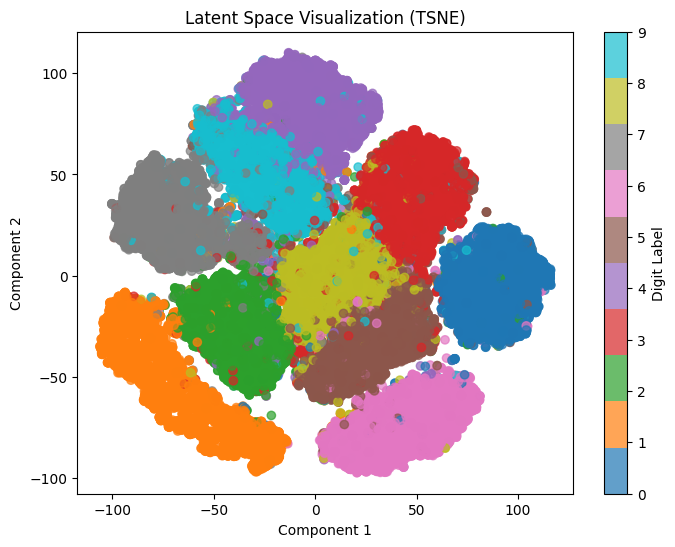

In [86]:
plot_latent_space(vae2, train_loader, method="tsne")

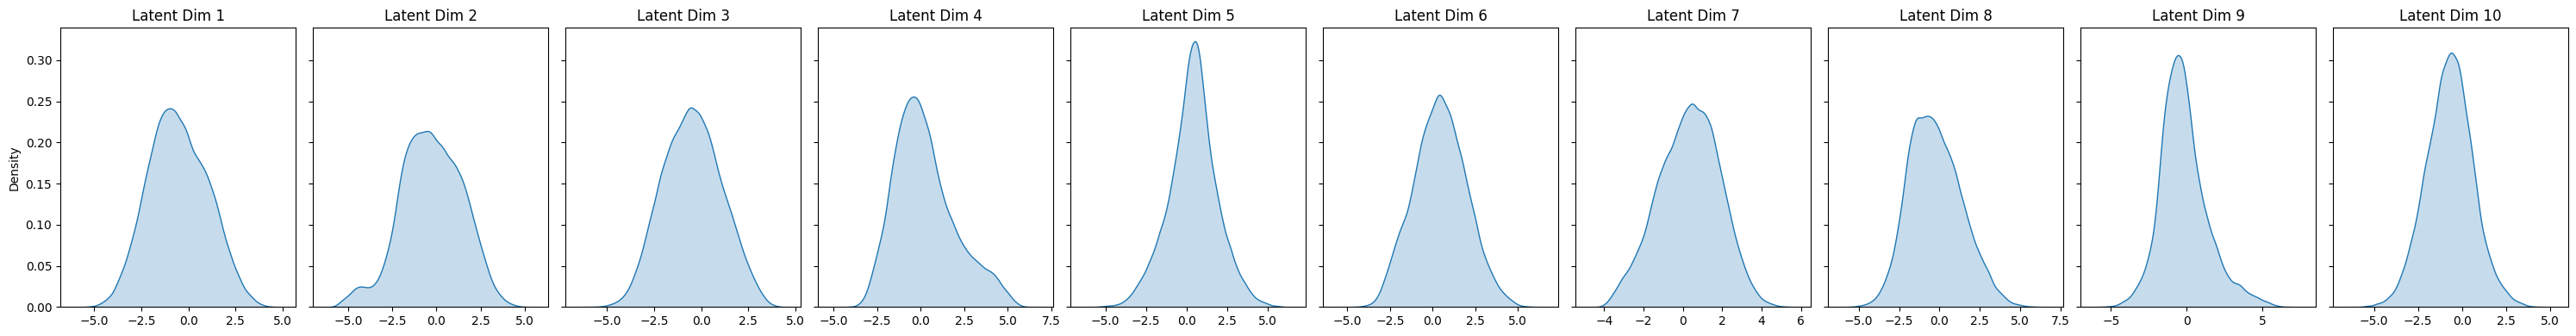

In [87]:
# This helps to see how well the latent space approximates a Gaussian distribution.
plot_latent_distributions(vae2, train_loader)

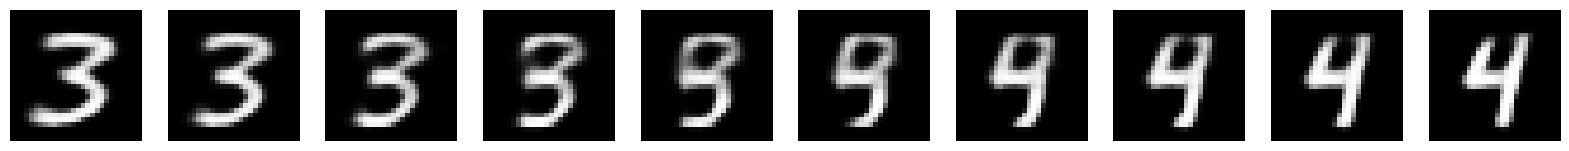

In [88]:
plot_interpolation(vae2, train_loader, num_steps=10)

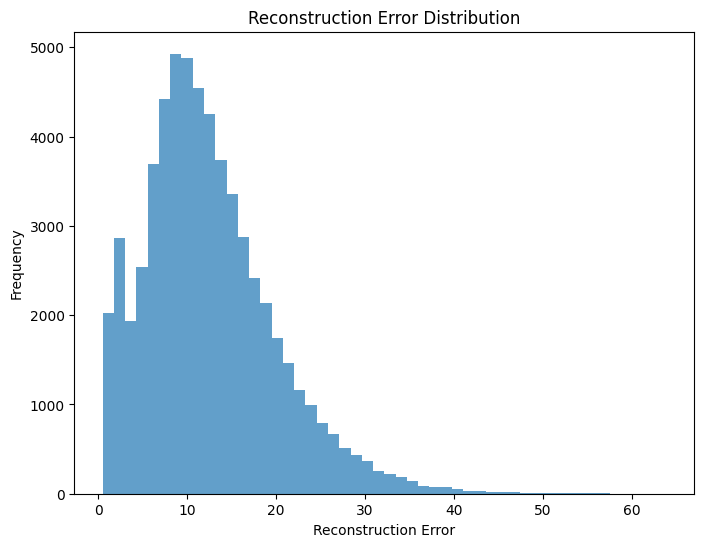

In [89]:
plot_reconstruction_error(vae2, train_loader)